# Weather Classification

# Imports

In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, PowerTransformer

# Model Selection and Metrics
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

# Functions

In [100]:
def check_nulls_dupes(df):
  print(f"The Amount of Null Values: {df.isna().sum()}")
  print(f"The Amount of Duplicated Values: {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 8))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 8))
  sns.countplot(x=target)
  plt.xlabel("Target Classes")
  plt.ylabel("Counts")
  plt.show()

def plot_dataset(df, visual_type):
  
  plt.figure(figsize=(16,16))
  cols = len(df.columns)
  rows = (cols +3)//4
  
  for idx, col in enumerate(df.columns):
    plt.subplot(rows, 4, idx+1)
    plt.title(col)
    sns.histplot(data=df[col], kde=True) if visual_type == "hist" else sns.boxplot(df[col])
    plt.xlabel(col)
  
  plt.tight_layout()
  plt.show()

def aggregate_dataset(df, interested_columns, agg_col, function):
  
  for col in interested_columns:
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    plt.figure(figsize=(12, 8))
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
    plt.show()

def create_column_transformer(cat_cols, numeric_cols):
  
  cat_transformer = Pipeline(
    steps=[
      ("encoder", OneHotEncoder())
    ]
  )
  
  numeric_transformer = Pipeline(
    steps =[
      ("scaler", MinMaxScaler()),
      ("PowerTransformer", PowerTransformer())
    ]
  )
  
  return ColumnTransformer(
    transformers=[
      ("cat", cat_transformer, cat_cols),
      ("numeric", numeric_transformer, numeric_cols)
    ]
  )

def create_sklearn_pipeline(preprocessor, model, kbest=None):
  
  steps = [
      ("preprocessor", preprocessor),
      ("model", model)
    ]
  
  if kbest:
    steps.insert(1, ("Feature-Selection", kbest))
    
  return Pipeline(
    steps = steps
  )

def pca_analysis(X, preprocessor):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline(preprocessor, pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append(
      {
        "Component": component,
        "CumSum": cumsum
      }
    )
  
  performance_df = pd.DataFrame(metric_tracker)
  plt.figure(figsize=(12, 8))
  plt.title("PCA Analysis")
  sns.barplot(data=performance_df, x="Component", y="CumSum")
  plt.xlabel("Components")
  plt.ylabel("CumSum")
  plt.show()
  print(performance_df)

def plot_confusion_matrix(y_true, y_pred, model_name):
  
  plt.figure(figsize=(10, 7))
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Confusion Matrix For: {model_name}")
  plt.ylabel("Predicted Labels")
  plt.xlabel("True Labels")
  plt.show()

def grab_selected_models(names):
  
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "DUMMY": DummyClassifier(strategy="uniform")
  }
  
  return [models[model_name] for model_name in names]

def get_metrics(y, predictions):
    acc_metric = accuracy_score(y, predictions)
    recall_metric = recall_score(y, predictions, average='macro')
    precision_metric = precision_score(y, predictions, average='macro')
    f1_metric = f1_score(y, predictions, average='macro')
    
    return [acc_metric,recall_metric, precision_metric, f1_metric]

def evaluate_model(model, X, y, metric):
  
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10,random_state=1)
  scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
  preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
  acc, recall_metric, precision_metric, f1_metric = get_metrics(y, preds)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(recall_metric,3),
    round(precision_metric,3),
    round(f1_metric,3)
  ]

def test_selected_models(preprocessor, model_names, models, X, y, scoring_metric, kbest=None):
  
  metric_tracker = []
  
  for model, model_name in zip(models, model_names):
    pipeline = create_sklearn_pipeline(preprocessor, model, kbest) if kbest else create_sklearn_pipeline(preprocessor, model) 
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "recall-Score":scores[4],
      "precision-Score":scores[5],
      "F1-Score":scores[6]
    })
  
  performance_df = pd.DataFrame(metric_tracker).sort_values(by="Mean", ascending=False)
  print(performance_df)

def test_kbest_columns(preprocessor, X, y, model, model_name, kbest):
  
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = create_sklearn_pipeline(preprocessor, model, metric)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)

    metric_tracker.append({
        "Model": model_name,
        "K":k,
        "acc_metric": acc,
        "f1_metric": f1_metric,
        "recall":recall_metric,
        "precision":precision_metric
      })
  
  return pd.DataFrame(metric_tracker)

def optimization_search(preprocessor, model_names, models,X, y, optimizer_class, param_distributions, scoring_metric, kbest):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  
  for model_name, model in zip(model_names, models):
    model_pipeline = create_sklearn_pipeline(preprocessor,model, kbest)
    current_params = param_distributions.get(model_name, {})
    opt_search= optimizer_class(model_pipeline, param_distributions=current_params, cv=10, scoring=scoring_metric, n_jobs=-1)
    opt_search.fit(X_train, y_train)
    
    best_model = opt_search.best_estimator_
    best_params = opt_search.best_params_
    y_pred = best_model.predict(X_test)
    
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
      
    plot_confusion_matrix(y_test, y_pred, model_name)
    print(f"The Best Param: {best_params}")
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return pd.DataFrame(metric_tracker)

# EDA Analysis

In [5]:
df = pd.read_csv("/Users/maukanmir/Downloads/weather_classification_data.csv")
df

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy
...,...,...,...,...,...,...,...,...,...,...,...
13195,10.0,74,14.5,71.0,overcast,1003.15,1,Summer,1.0,mountain,Rainy
13196,-1.0,76,3.5,23.0,cloudy,1067.23,1,Winter,6.0,coastal,Snowy
13197,30.0,77,5.5,28.0,overcast,1012.69,3,Autumn,9.0,coastal,Cloudy
13198,3.0,76,10.0,94.0,overcast,984.27,0,Winter,2.0,inland,Snowy


# Check For Nulls and Dupes

In [6]:
check_nulls_dupes(df)

The Amount of Null Values: Temperature             0
Humidity                0
Wind Speed              0
Precipitation (%)       0
Cloud Cover             0
Atmospheric Pressure    0
UV Index                0
Season                  0
Visibility (km)         0
Location                0
Weather Type            0
dtype: int64
The Amount of Duplicated Values: 0


# Check for Target Class Distribution

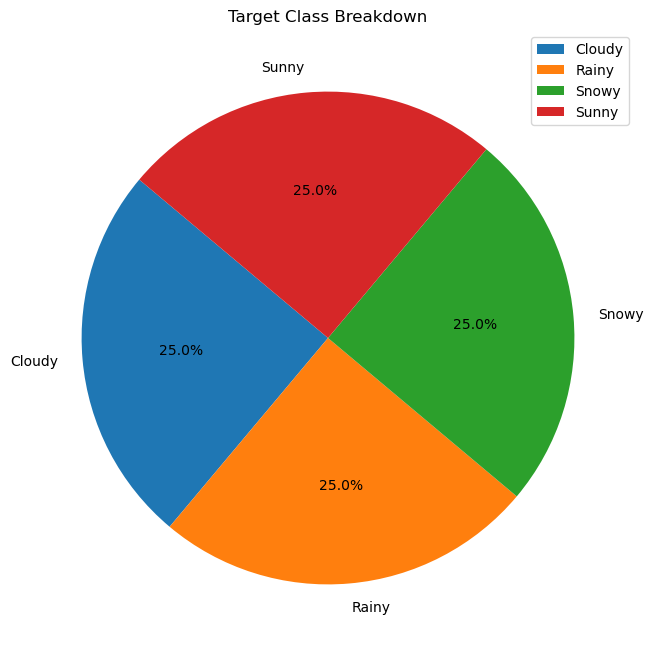

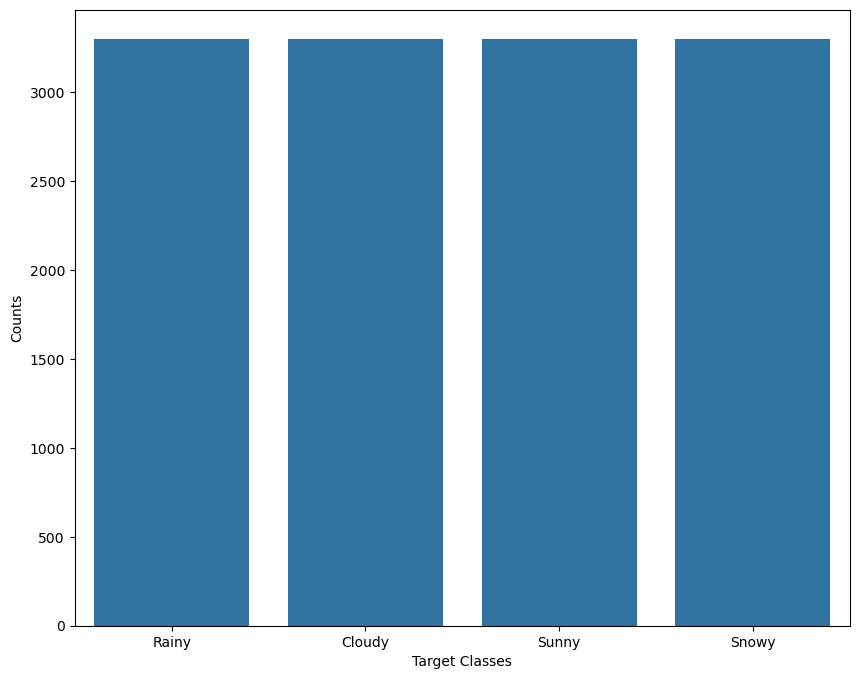

In [7]:
check_class_imbalance(df["Weather Type"])

#### We have a completely balanced dataset.

In [8]:
df.dtypes

Temperature             float64
Humidity                  int64
Wind Speed              float64
Precipitation (%)       float64
Cloud Cover              object
Atmospheric Pressure    float64
UV Index                  int64
Season                   object
Visibility (km)         float64
Location                 object
Weather Type             object
dtype: object

In [9]:
df.describe()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km)
count,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000
mean,19.127576,68.710833,9.832197,53.644394,1005.827896,4.005758,5.462917
std,17.386327,20.194248,6.908704,31.946541,37.199589,3.856600,3.371499
min,-25.000000,20.000000,0.000000,0.000000,800.120000,0.000000,0.000000
25%,4.000000,57.000000,5.000000,19.000000,994.800000,1.000000,3.000000
50%,21.000000,70.000000,9.000000,58.000000,1007.650000,3.000000,5.000000
75%,31.000000,84.000000,13.500000,82.000000,1016.772500,7.000000,7.500000
max,109.000000,109.000000,48.500000,109.000000,1199.210000,14.000000,20.000000


# Let's visualize our dataset

<AxesSubplot:>

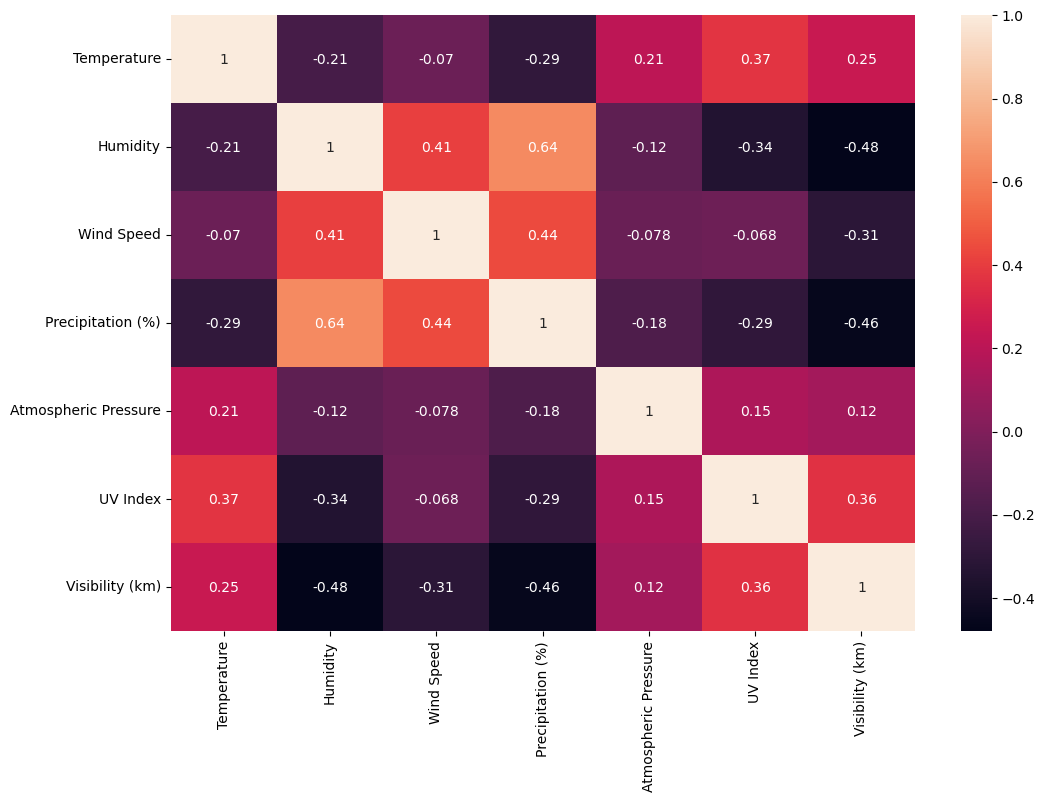

In [10]:
relations = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(data=relations, annot=True)

# Histogram

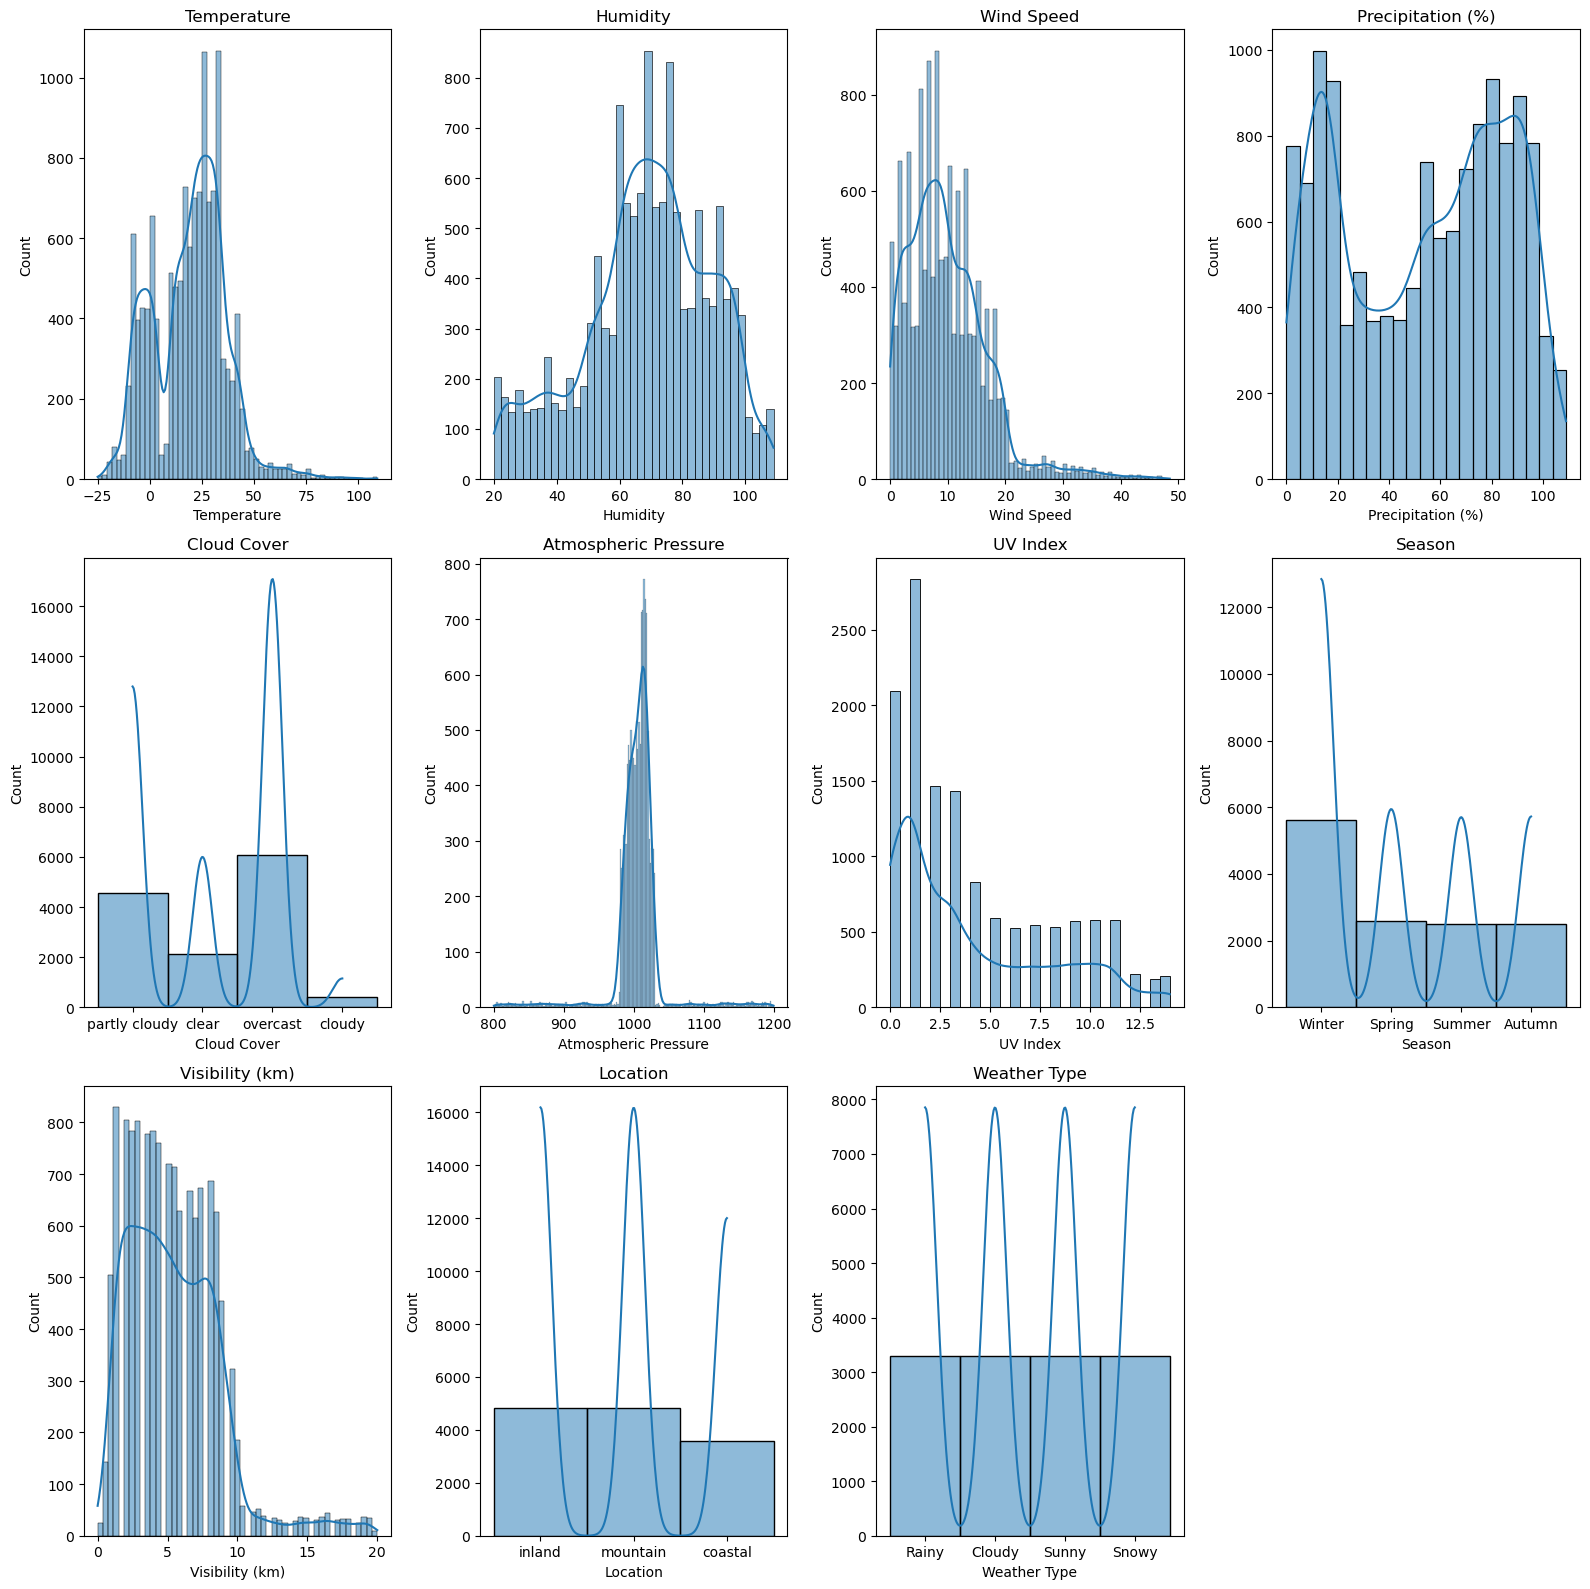

In [13]:
plot_dataset(df, "hist")

# Box Plot

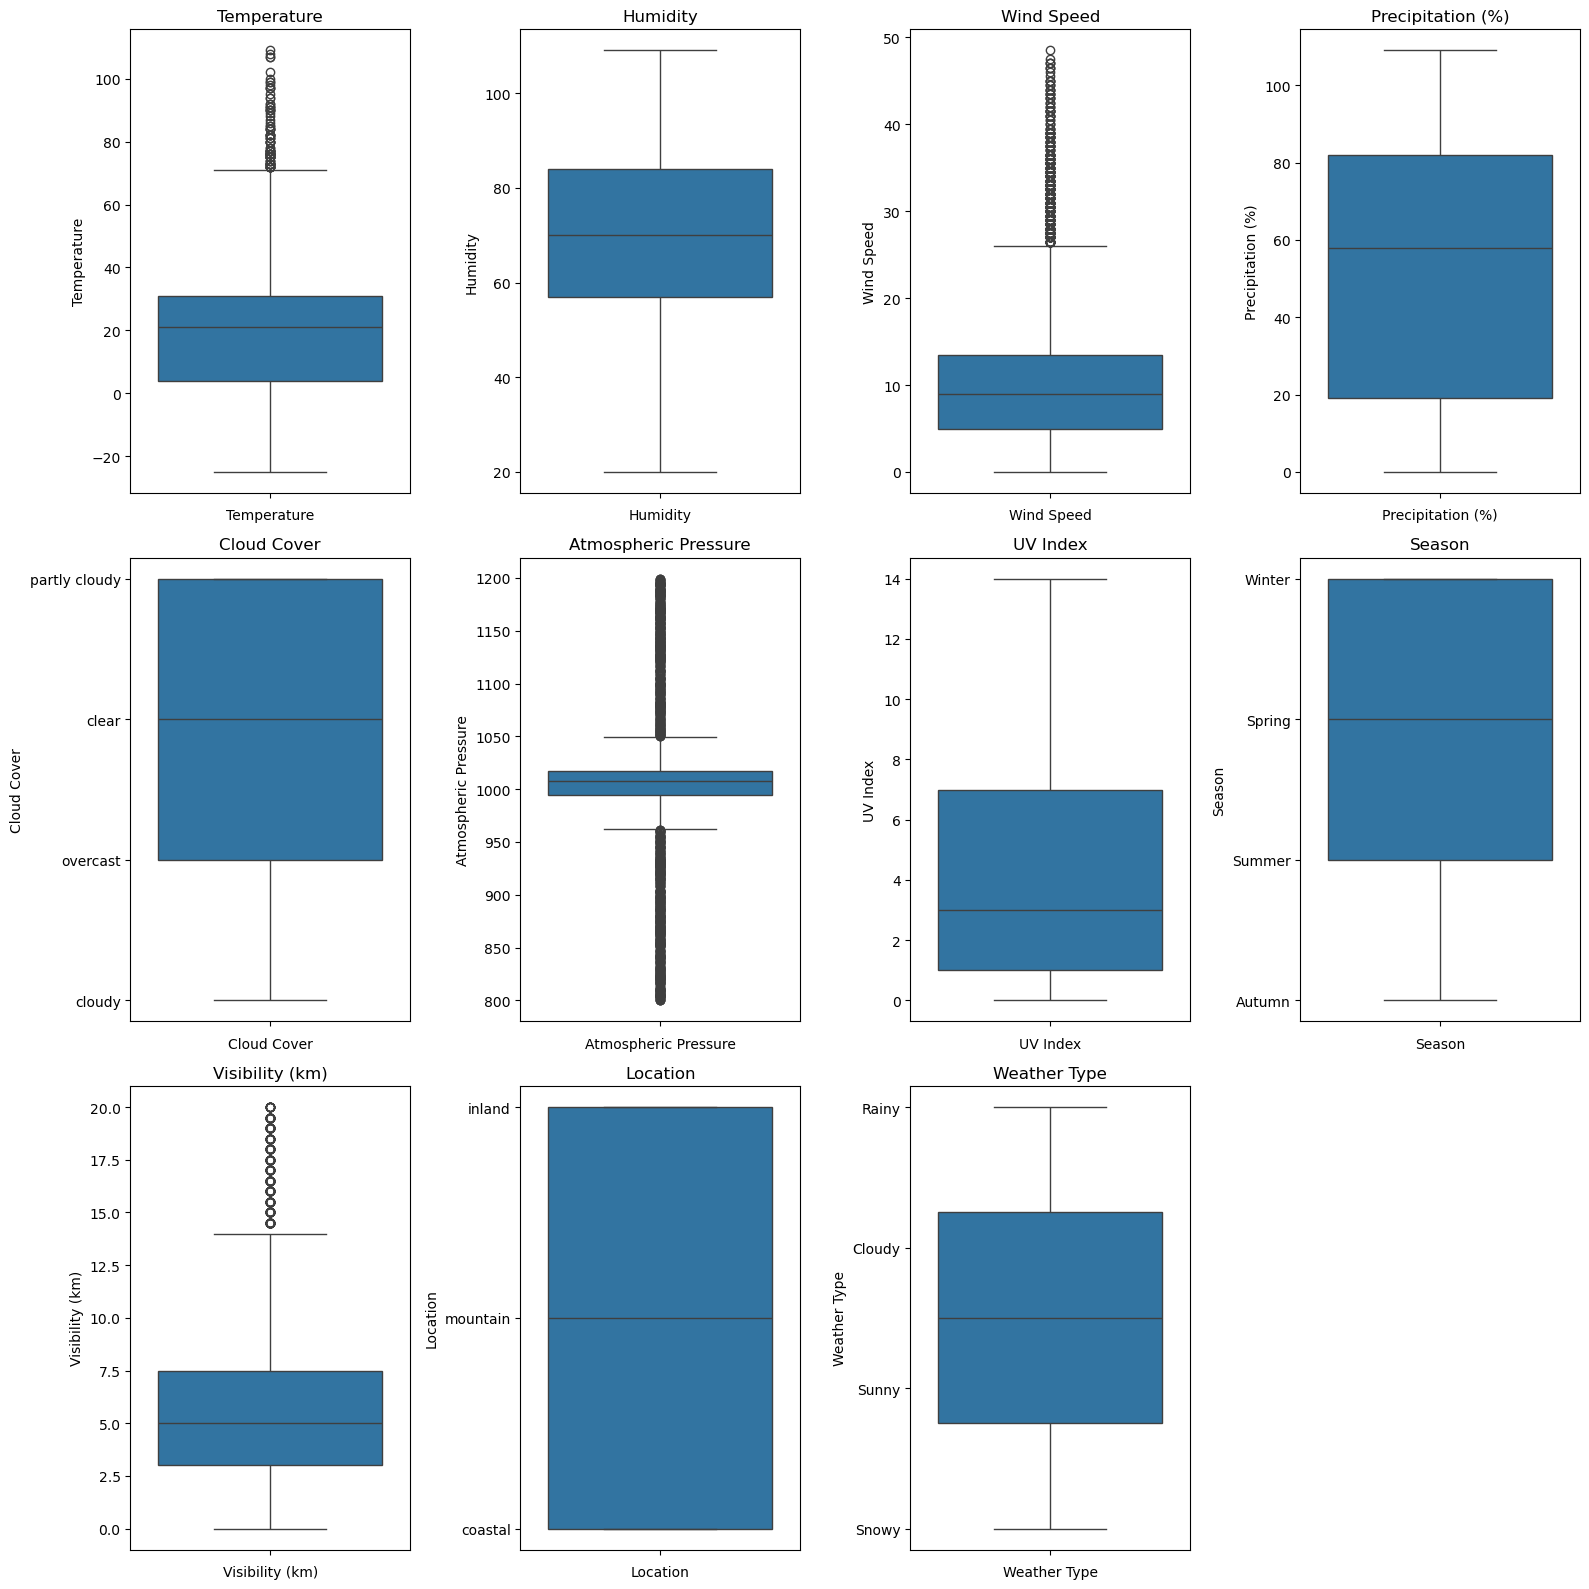

In [14]:
plot_dataset(df, "boxplot")

# Data Aggregations

# Sum Aggregations

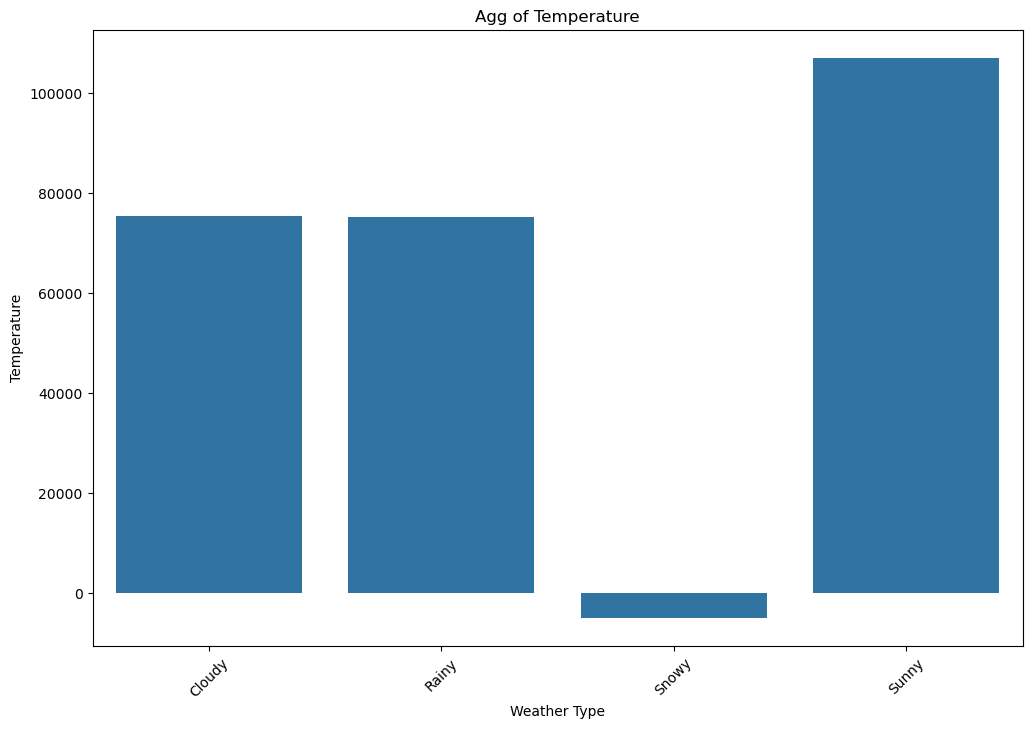

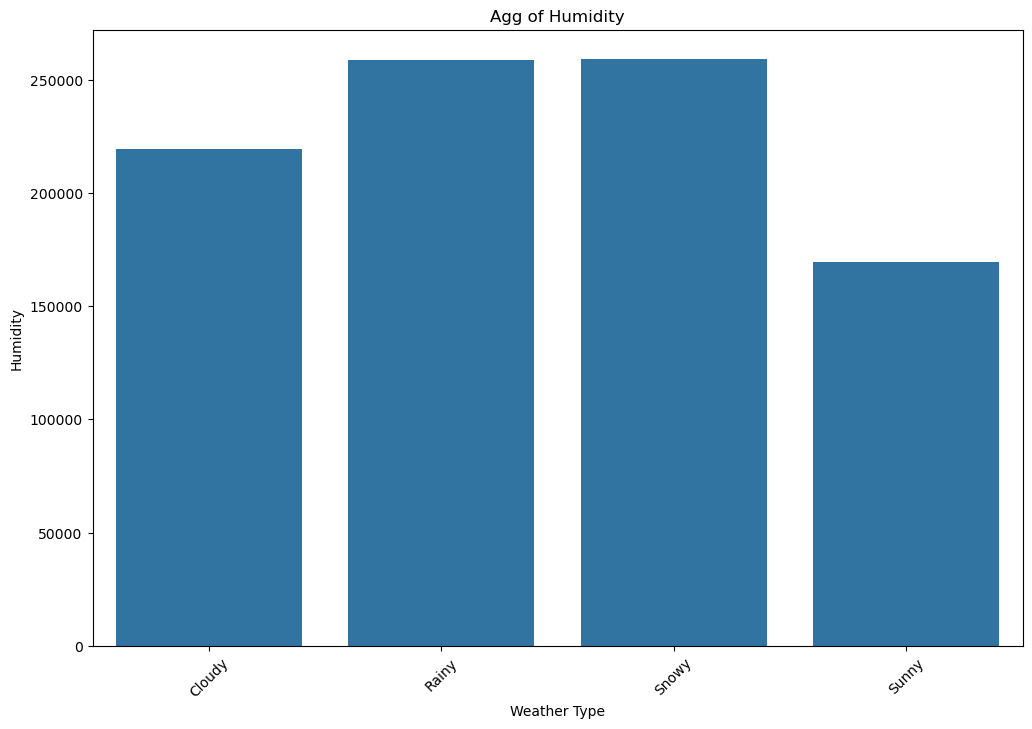

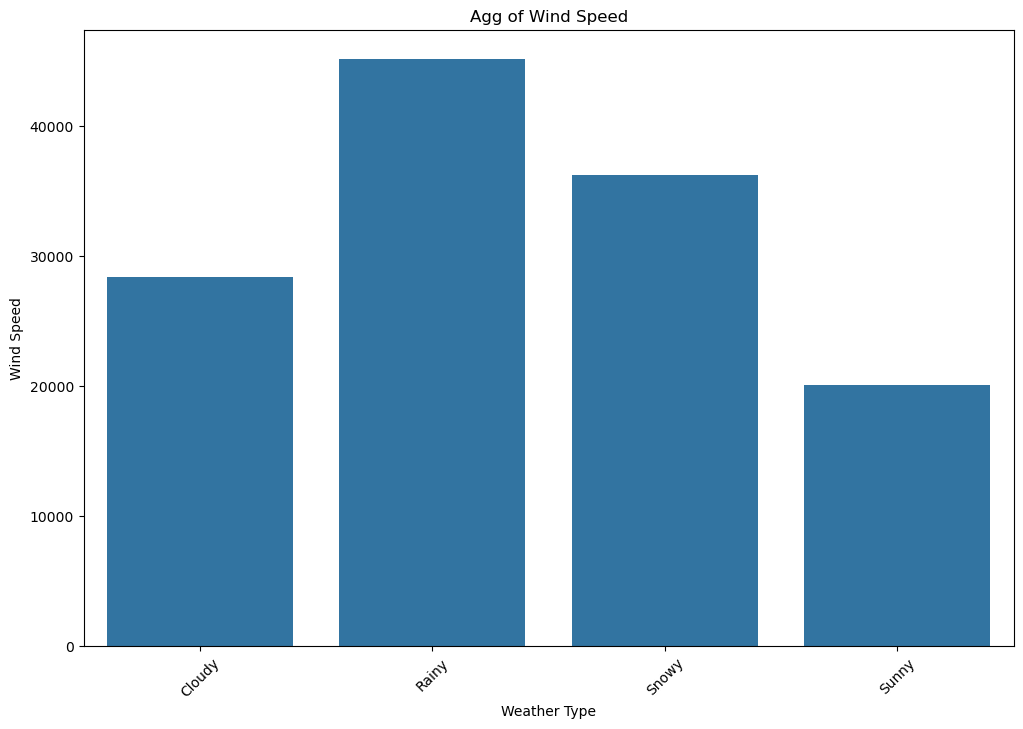

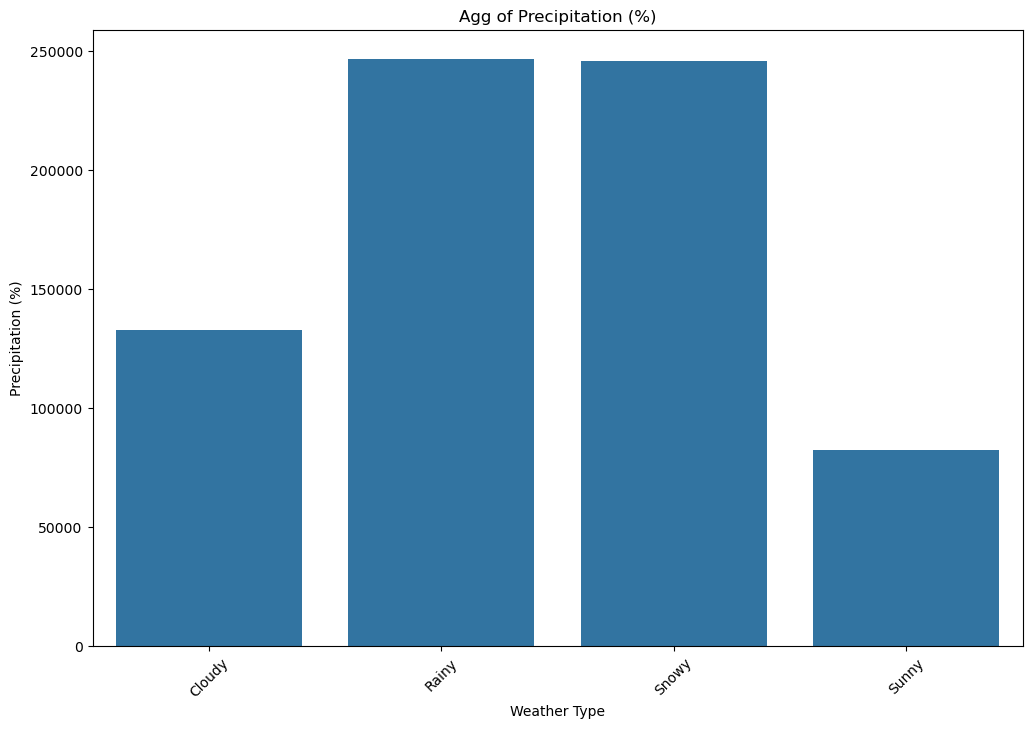

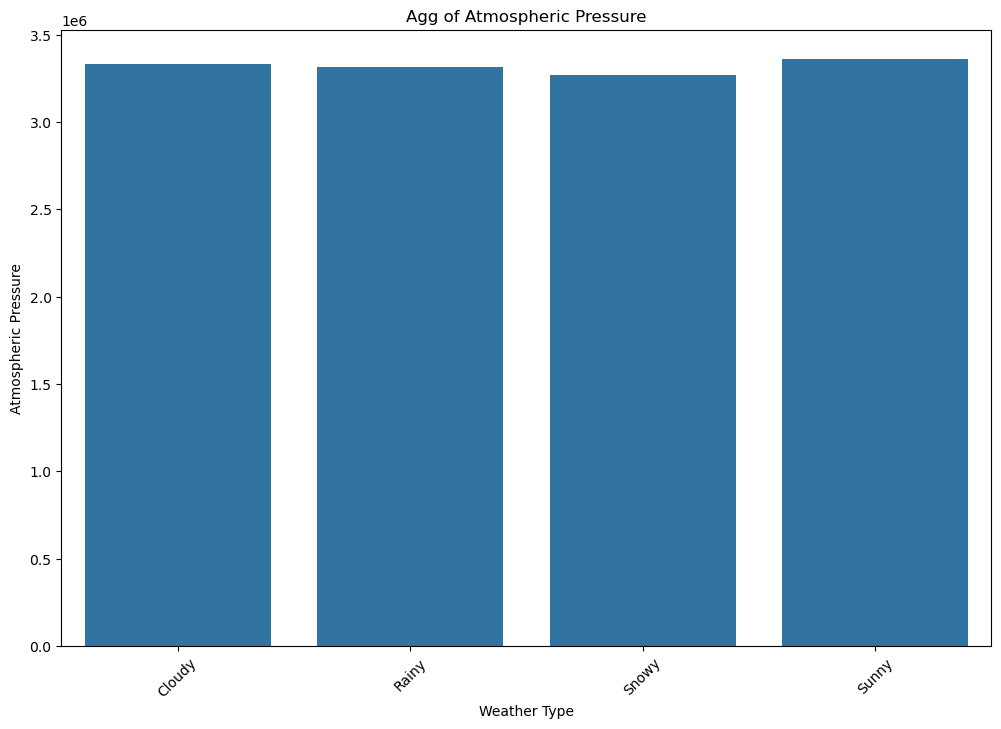

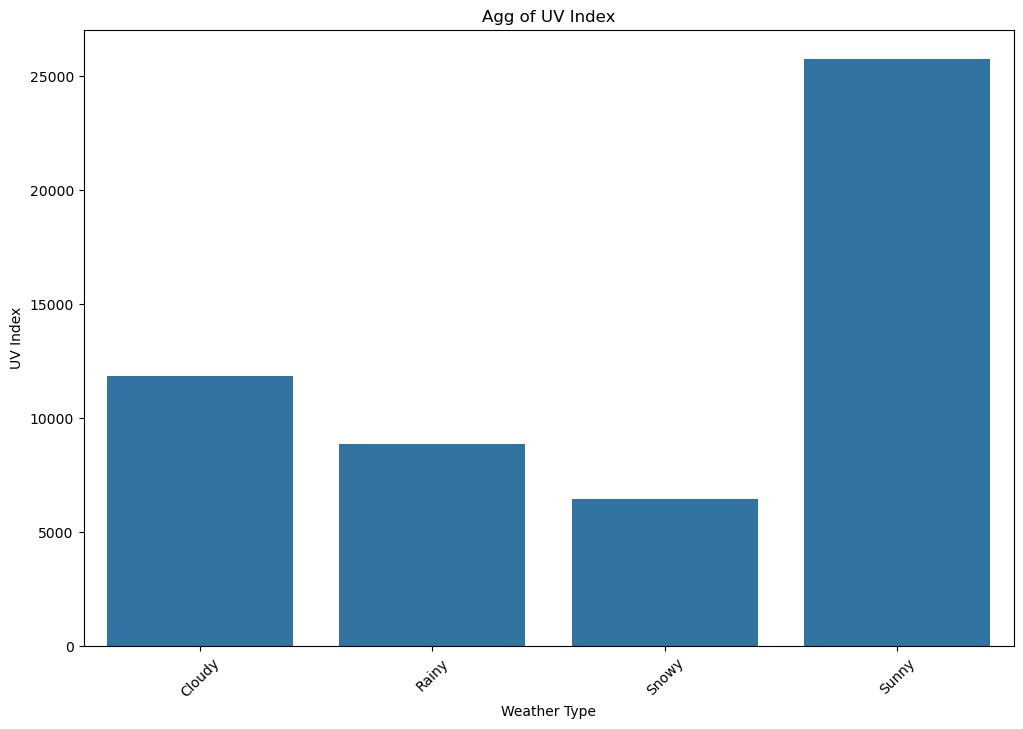

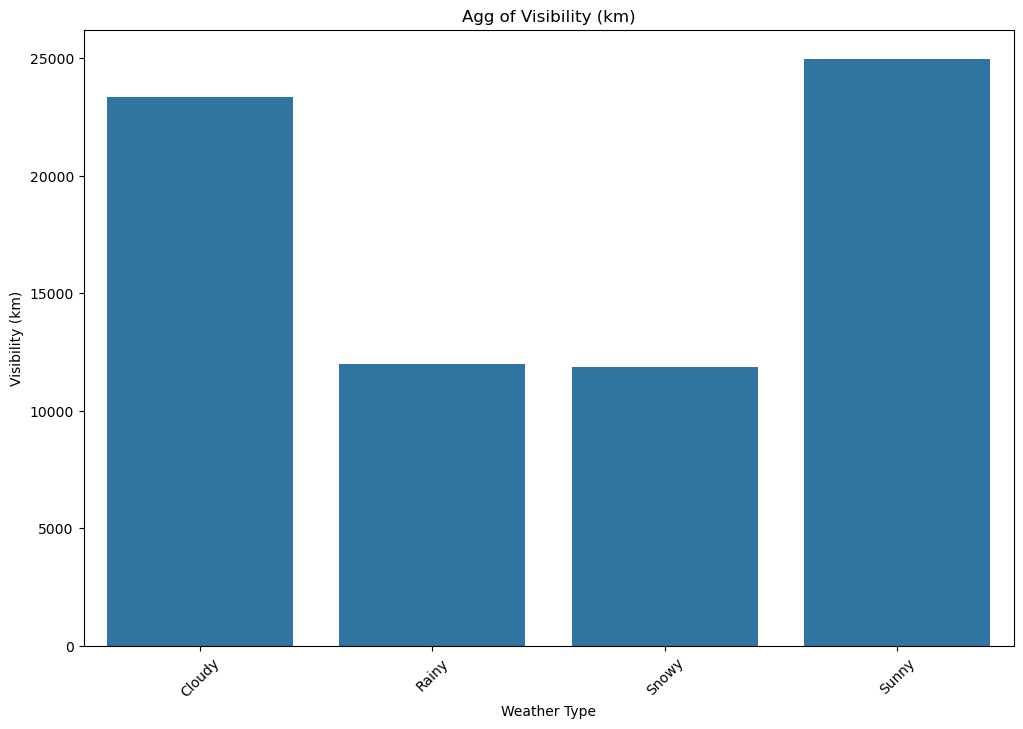

In [45]:
aggregate_dataset(df, numeric_features.columns, "Weather Type", "sum")

# Mean Aggregations

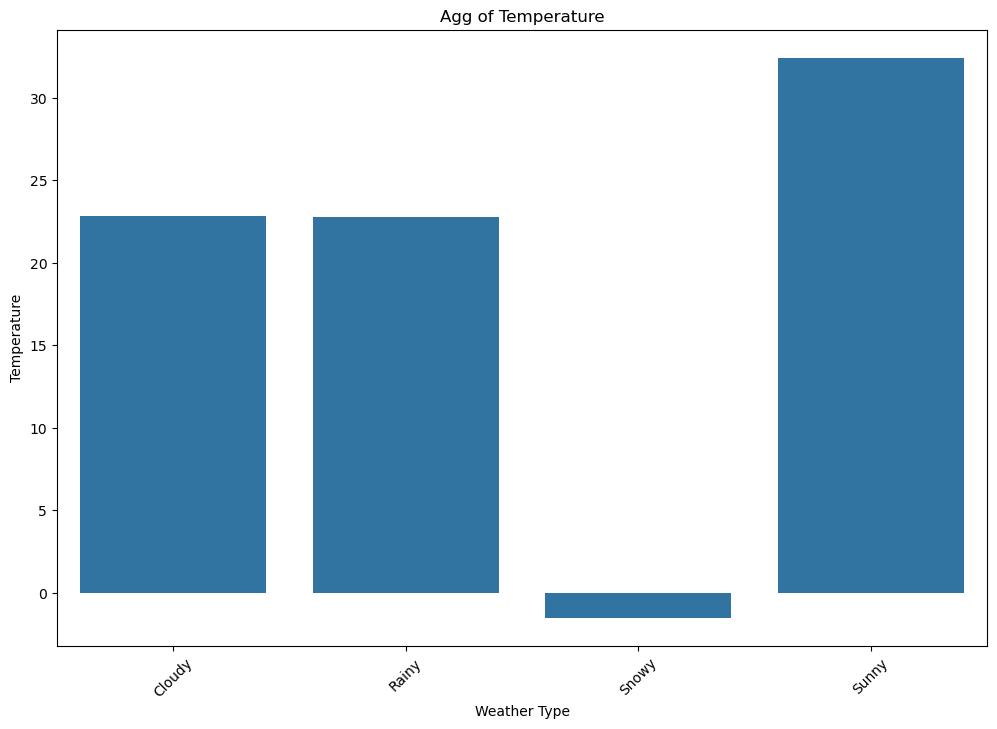

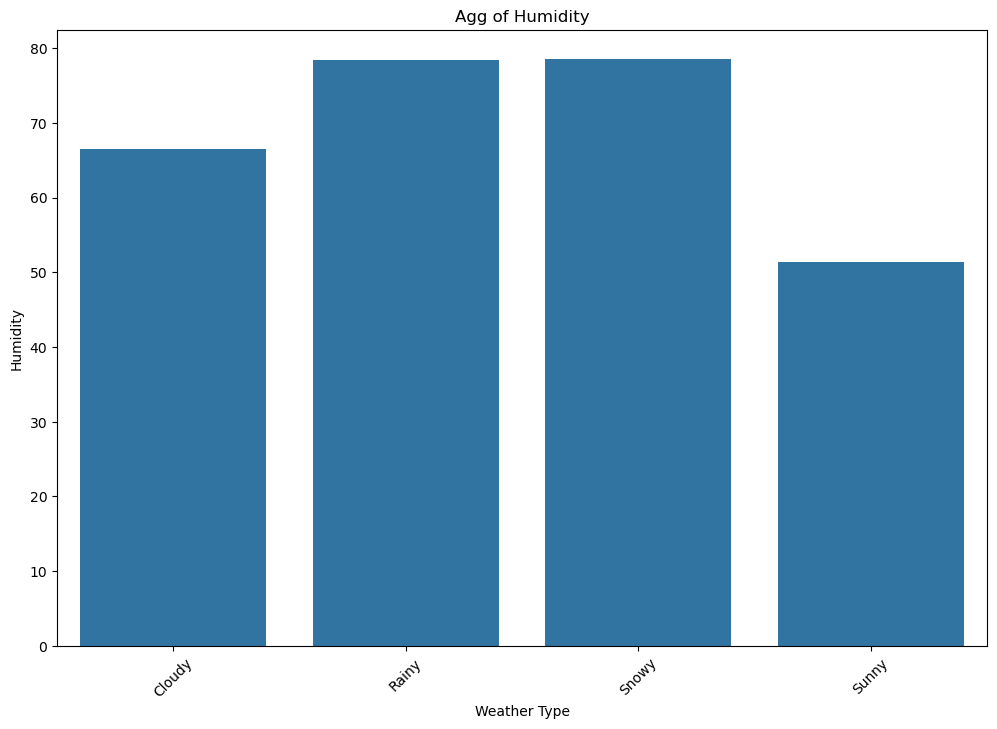

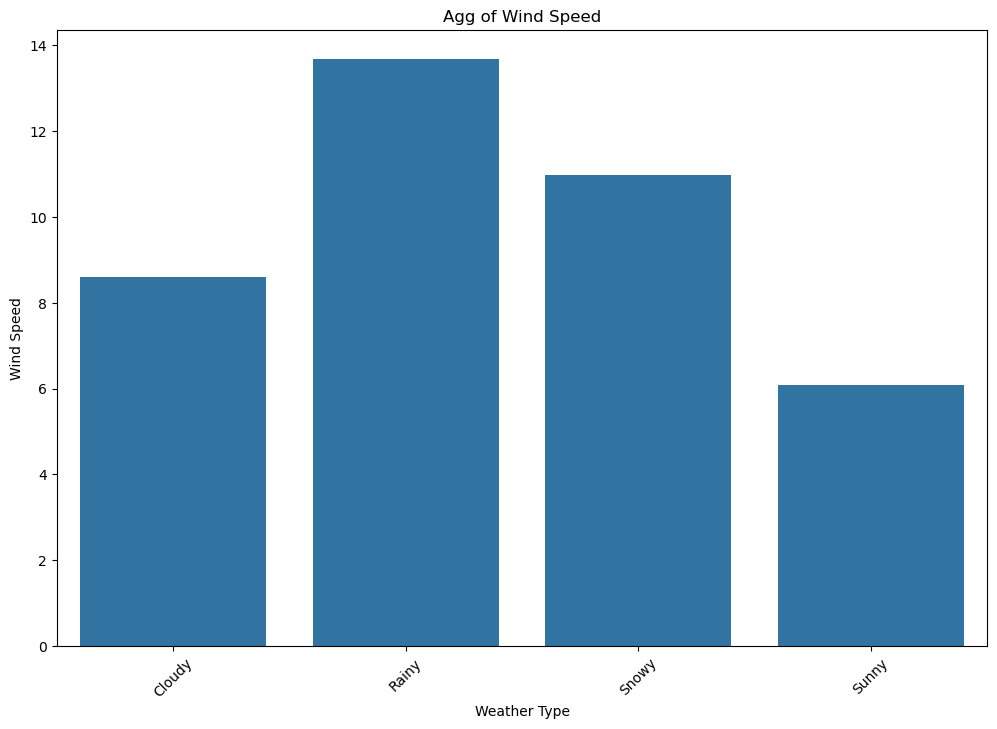

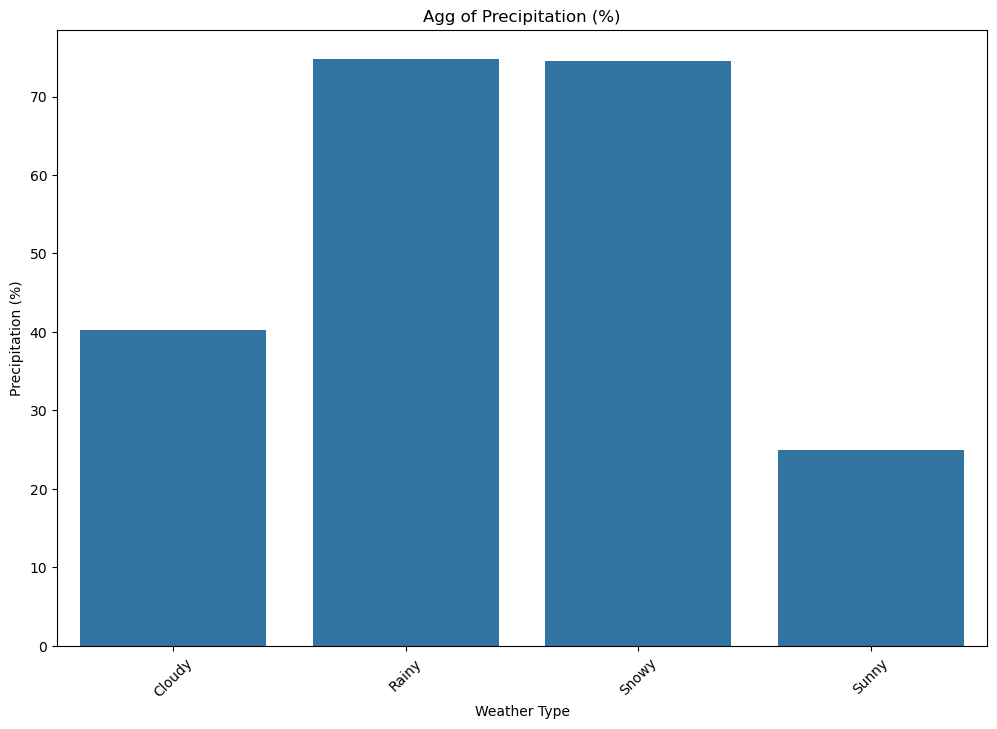

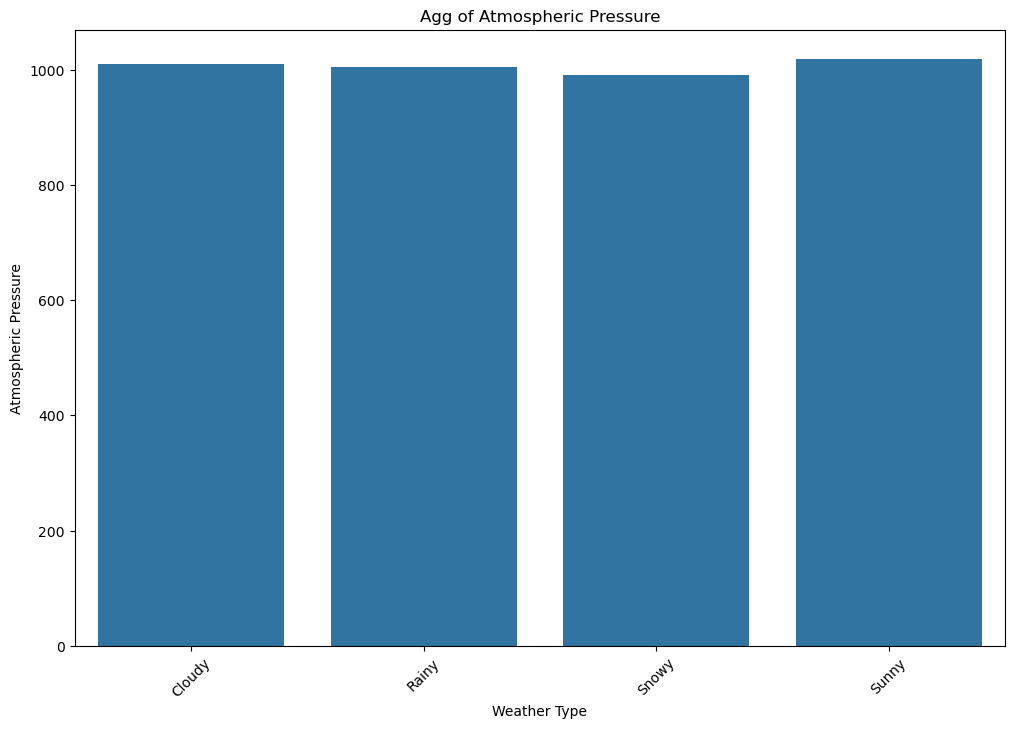

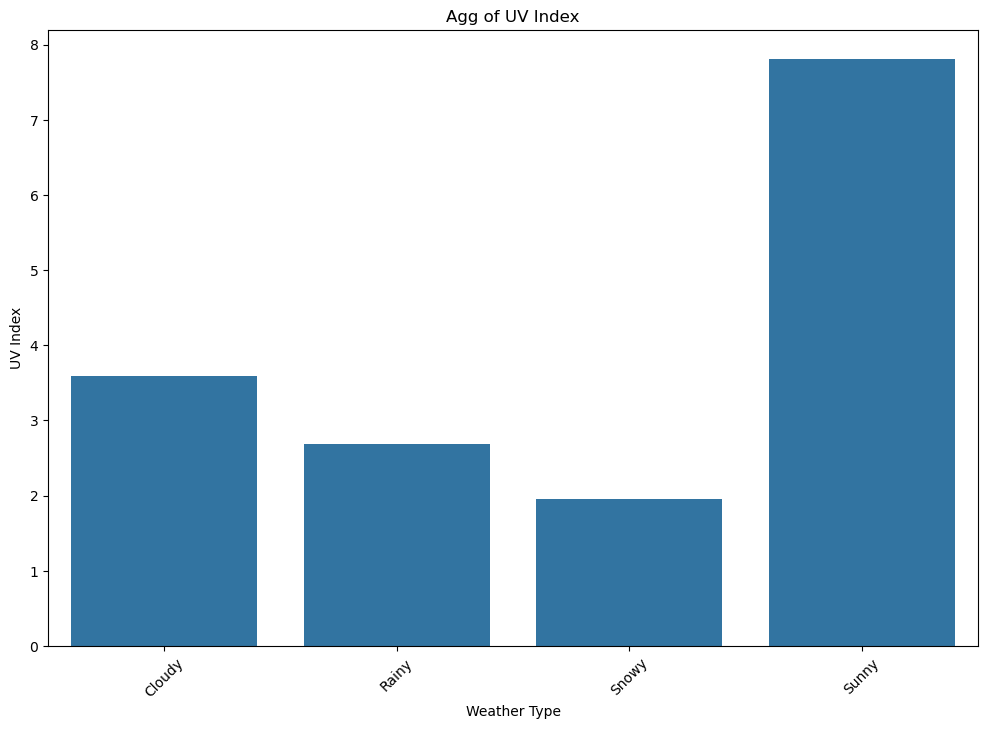

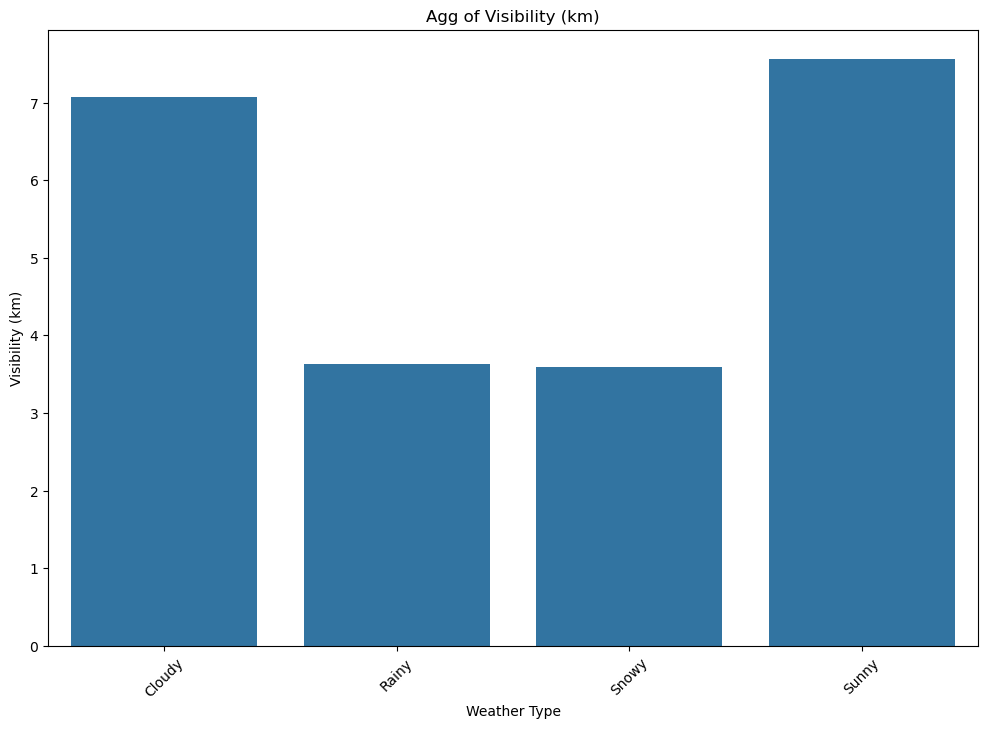

In [46]:
aggregate_dataset(df, numeric_features.columns, "Weather Type", "mean")

# Split numeric and categorical columns

In [27]:
cat_features = df.select_dtypes(include="object").drop("Weather Type", axis=1)
numeric_features = df.select_dtypes(include=["int64","float64"])

# Create Preprocessor

In [32]:
preprocessor = create_column_transformer(cat_features.columns, numeric_features.columns)
preprocessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 Index(['Cloud Cover', 'Season', 'Location'], dtype='object')),
                                ('numeric',
                                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 Index(['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)',
       'Atmospheric Pressure', 'UV Index', 'Visibility (km)'],
      dtype='object'))])

# Split Features

In [88]:
X = df.drop('Weather Type', axis=1)
y = df["Weather Type"]

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# PCA Analysis

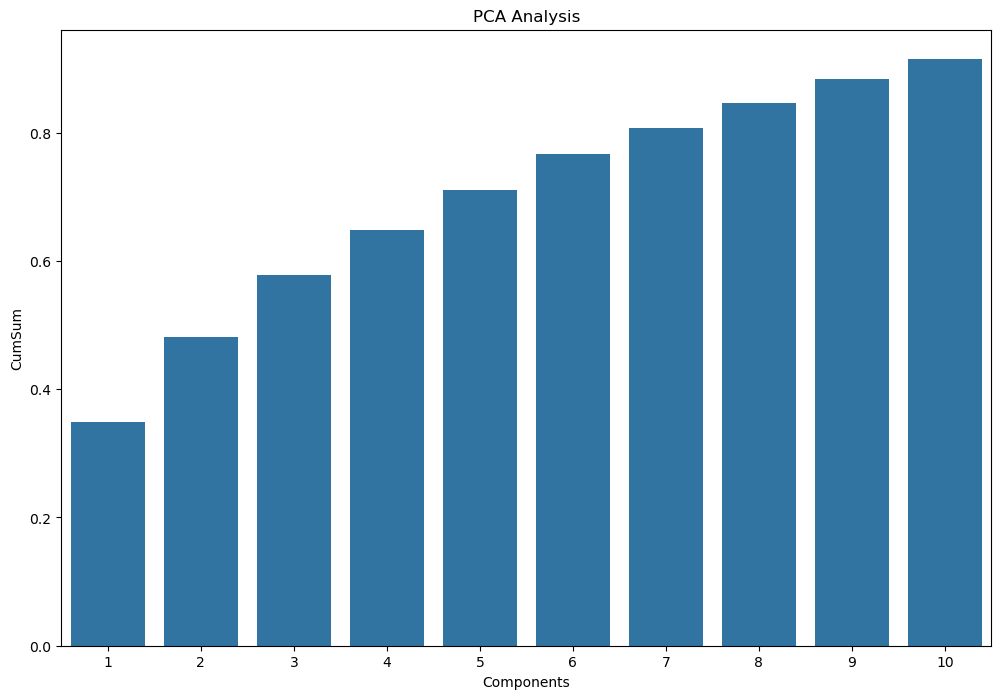

   Component    CumSum
0          1  0.348695
1          2  0.481099
2          3  0.578805
3          4  0.648945
4          5  0.710646
5          6  0.767000
6          7  0.807602
7          8  0.846927
8          9  0.884370
9         10  0.915071


In [56]:
pca_analysis(X, preprocessor)

# Create Metrics

In [70]:
acc_metric = make_scorer(accuracy_score, greater_is_better=True)
f1_metric = make_scorer(f1_score, greater_is_better=True, average="macro")
precision_metric = make_scorer(precision_score, greater_is_better=True, average='macro')
recall_metric = make_scorer(recall_score, greater_is_better=True, average='macro')

# Test Baseline Model

In [89]:
model_name = ["DUMMY"]
models = grab_selected_models(model_name)
test_selected_models(preprocessor,model_name, models, X, y_encoded, acc_metric)

   Model   Mean  Var    STD  Test-Acc  recall-Score  precision-Score  F1-Score
0  DUMMY  0.251  0.0  0.011     0.254         0.254            0.254     0.254


# Test Kbest Columns

# Testing With Mutual Info

In [90]:
model_name = ["LR"]
models = grab_selected_models(model_name)[0]
metric = mutual_info_classif
test_kbest_columns(preprocessor, X, y_encoded, models, model_name[0], metric)

,Model,K,acc_metric,f1_metric,recall,precision
0,LR,1,0.555785,0.524736,0.555785,0.518175
1,LR,2,0.630395,0.620028,0.630395,0.625004
2,LR,3,0.763315,0.758992,0.763315,0.761885
3,LR,4,0.798898,0.795646,0.798898,0.797531
4,LR,5,0.870064,0.869915,0.870064,0.870181
5,LR,6,0.882231,0.882640,0.882231,0.884224
6,LR,7,0.880624,0.881040,0.880624,0.882552
7,LR,8,0.872360,0.872604,0.872360,0.873947
8,LR,9,0.876722,0.876911,0.876722,0.877764
9,LR,10,0.876263,0.876405,0.876263,0.877114


# About 5-10 columns holds roughly the same performance across the board.

# Testing with Fstat

In [91]:
model_name = ["LR"]
models = grab_selected_models(model_name)[0]
metric = f_classif
test_kbest_columns(preprocessor, X, y_encoded, models, model_name[0], metric)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,K,acc_metric,f1_metric,recall,precision
0,LR,1,0.412994,0.312327,0.412994,0.324671
1,LR,2,0.634757,0.643753,0.634757,0.669038
2,LR,3,0.811983,0.813699,0.811983,0.831083
3,LR,4,0.843205,0.844092,0.843205,0.861159
4,LR,5,0.881543,0.881934,0.881543,0.883474
5,LR,6,0.870294,0.870614,0.870294,0.872135
6,LR,7,0.876033,0.876155,0.876033,0.876761
7,LR,8,0.876722,0.876856,0.876722,0.877663
8,LR,9,0.875574,0.875666,0.875574,0.876380
9,LR,10,0.876263,0.876454,0.876263,0.877225


# Between the two metrics, the scoring is the virtually the same. However, because I am curious, I will test both.

# Let's test more models

In [92]:
model_names = ["RFC", "XGB", "GBC", "DTC", "LR", "SVC", "KNN"]
models = grab_selected_models(model_names)
kbest = SelectKBest(score_func=mutual_info_classif, k=8)
performance_df = test_selected_models(preprocessor, model_names, models, X, y_encoded, acc_metric)

  Model   Mean  Var    STD  Test-Acc  recall-Score  precision-Score  F1-Score
0   RFC  0.915  0.0  0.007     0.914         0.914            0.914     0.914
1   XGB  0.914  0.0  0.008     0.916         0.916            0.916     0.916
2   GBC  0.913  0.0  0.007     0.913         0.913            0.913     0.913
5   SVC  0.909  0.0  0.008     0.909         0.909            0.909     0.909
3   DTC  0.908  0.0  0.008     0.906         0.906            0.906     0.906
6   KNN  0.896  0.0  0.008     0.895         0.895            0.896     0.896
4    LR  0.877  0.0  0.008     0.877         0.877            0.877     0.877


In [93]:
kbest = SelectKBest(score_func=mutual_info_classif, k=7)
performance_df = test_selected_models(preprocessor, model_names, models, X, y_encoded, acc_metric)

  Model   Mean  Var    STD  Test-Acc  recall-Score  precision-Score  F1-Score
0   RFC  0.915  0.0  0.007     0.916         0.916            0.916     0.916
1   XGB  0.914  0.0  0.008     0.916         0.916            0.916     0.916
2   GBC  0.913  0.0  0.007     0.912         0.913            0.913     0.913
5   SVC  0.909  0.0  0.008     0.909         0.909            0.909     0.909
3   DTC  0.908  0.0  0.008     0.907         0.907            0.907     0.907
6   KNN  0.896  0.0  0.008     0.895         0.895            0.896     0.896
4    LR  0.877  0.0  0.008     0.877         0.877            0.877     0.877


In [94]:
kbest = SelectKBest(score_func=mutual_info_classif, k=6)
performance_df = test_selected_models(preprocessor, model_names, models, X, y_encoded, acc_metric)

  Model   Mean  Var    STD  Test-Acc  recall-Score  precision-Score  F1-Score
0   RFC  0.915  0.0  0.007     0.915         0.915            0.916     0.916
1   XGB  0.914  0.0  0.008     0.916         0.916            0.916     0.916
2   GBC  0.913  0.0  0.007     0.912         0.913            0.913     0.913
3   DTC  0.909  0.0  0.008     0.906         0.906            0.906     0.906
5   SVC  0.909  0.0  0.008     0.909         0.909            0.909     0.909
6   KNN  0.896  0.0  0.008     0.895         0.895            0.896     0.896
4    LR  0.877  0.0  0.008     0.877         0.877            0.877     0.877


In [95]:
model_names = ["RFC", "XGB", "GBC", "DTC", "LR", "SVC", "KNN"]
models = grab_selected_models(model_names)
kbest = SelectKBest(score_func=mutual_info_classif, k=5)
performance_df = test_selected_models(preprocessor, model_names, models, X, y_encoded, acc_metric)

  Model   Mean  Var    STD  Test-Acc  recall-Score  precision-Score  F1-Score
0   RFC  0.915  0.0  0.007     0.914         0.914            0.914     0.914
1   XGB  0.914  0.0  0.008     0.916         0.916            0.916     0.916
2   GBC  0.913  0.0  0.007     0.913         0.913            0.913     0.913
5   SVC  0.909  0.0  0.008     0.909         0.909            0.909     0.909
3   DTC  0.908  0.0  0.008     0.906         0.906            0.906     0.906
6   KNN  0.896  0.0  0.008     0.895         0.895            0.896     0.896
4    LR  0.877  0.0  0.008     0.877         0.877            0.877     0.877


# Fstat Test

In [96]:
kbest = SelectKBest(score_func=f_classif, k=5)
performance_df = test_selected_models(preprocessor, model_names, models, X, y_encoded, acc_metric)

  Model   Mean  Var    STD  Test-Acc  recall-Score  precision-Score  F1-Score
0   RFC  0.915  0.0  0.007     0.915         0.915            0.915     0.915
1   XGB  0.914  0.0  0.008     0.916         0.916            0.916     0.916
2   GBC  0.913  0.0  0.007     0.912         0.913            0.913     0.913
5   SVC  0.909  0.0  0.008     0.909         0.909            0.909     0.909
3   DTC  0.908  0.0  0.008     0.906         0.906            0.906     0.906
6   KNN  0.896  0.0  0.008     0.895         0.895            0.896     0.896
4    LR  0.877  0.0  0.008     0.877         0.877            0.877     0.877


# Let's Optimize With Our Best Models

In [105]:
params = {
    'GBC': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 4, 5],
        'model__min_samples_split': [2, 4],
        'model__min_samples_leaf': [1, 2]
    },
    'XGB': {
        'model__n_estimators': [100, 150, 200],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.8, 1.0]
    },
    'RFC': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'LR': {
        'model__C': [0.01, 0.1, 1, 10],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear', 'saga']
    },
    'SVC': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
        'model__gamma': ['scale', 'auto'],
        'model__degree': [2, 3, 4]
    }
}

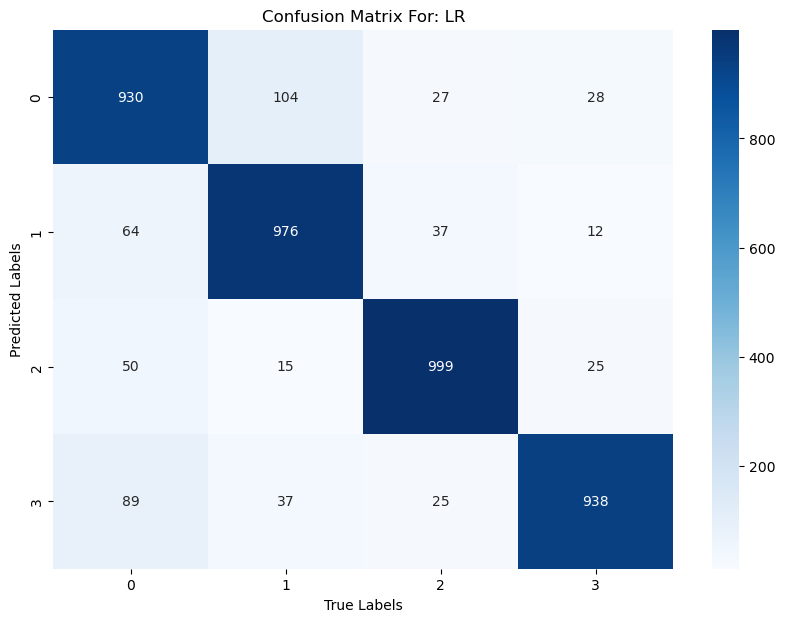

The Best Param: {'model__solver': 'saga', 'model__penalty': 'l1', 'model__C': 1}


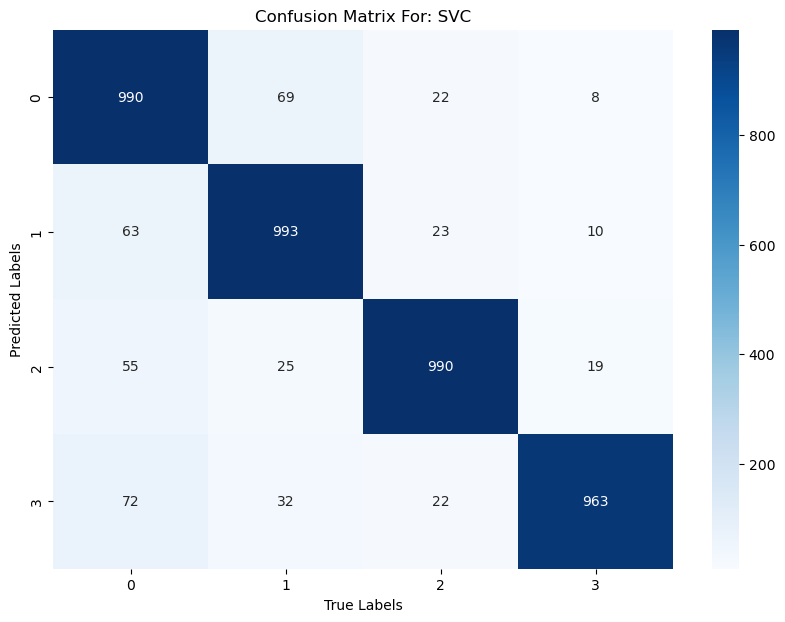

The Best Param: {'model__kernel': 'rbf', 'model__gamma': 'scale', 'model__degree': 2, 'model__C': 10}
  Model  Test-Acc  F1-Score  recall-Score  precision-Score
1   SVC  0.903581  0.904177      0.903581         0.906499
0    LR  0.882231  0.882623      0.882231         0.884103


In [103]:
model_names = ["LR", "SVC"]
models = grab_selected_models(model_names)
performance_df = optimization_search(preprocessor, model_names, models, X, y_encoded, RandomizedSearchCV, params, acc_metric, kbest)
print(performance_df.sort_values(by="Test-Acc", ascending=False))

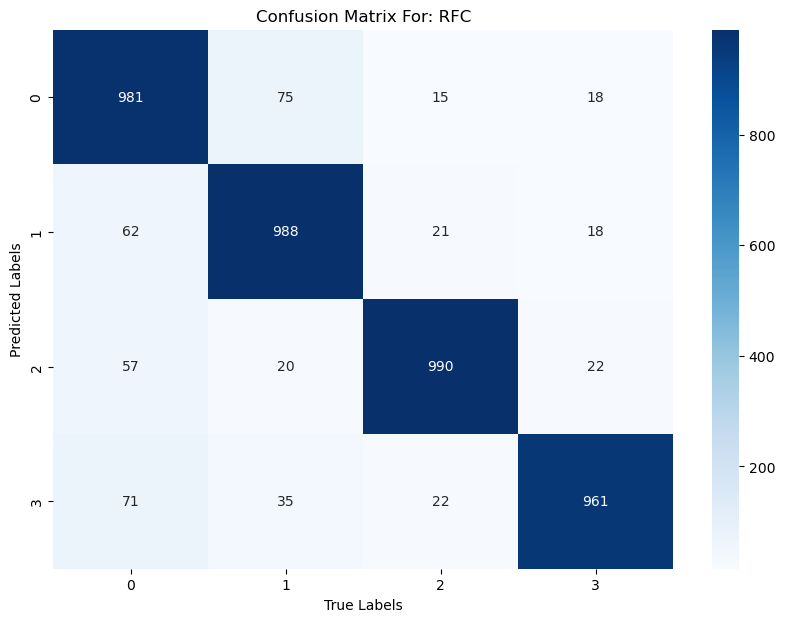

The Best Param: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 4, 'model__max_depth': 10}


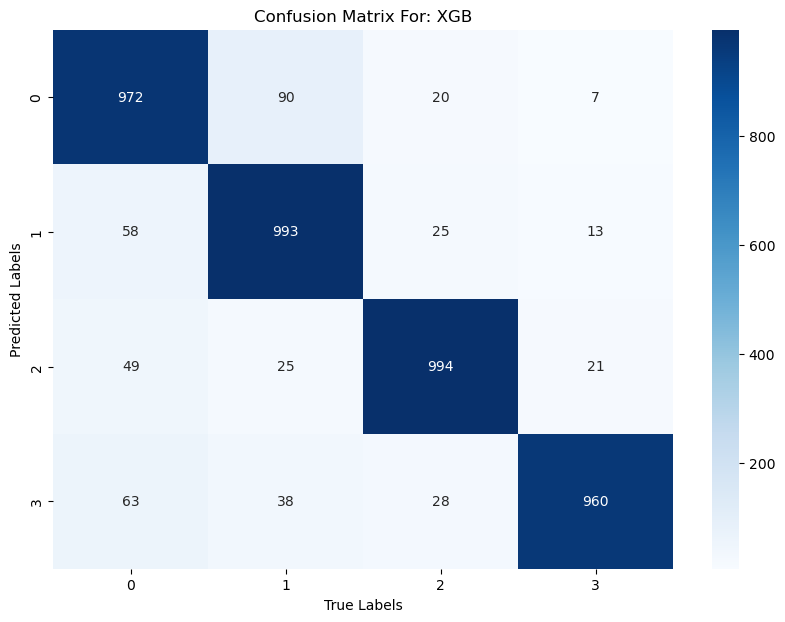

The Best Param: {'model__subsample': 0.6, 'model__n_estimators': 100, 'model__max_depth': 5, 'model__learning_rate': 0.05, 'model__colsample_bytree': 1.0}


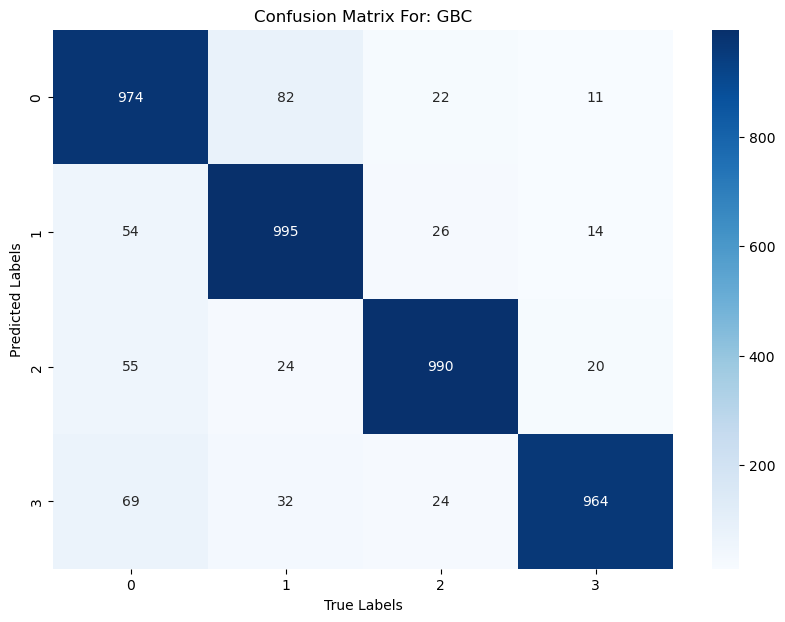

The Best Param: {'model__n_estimators': 300, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_depth': 5, 'model__learning_rate': 0.01}
  Model  Test-Acc  F1-Score  recall-Score  precision-Score
2   GBC  0.900597  0.901079      0.900597         0.902823
0   RFC  0.899908  0.900443      0.899908         0.902301
1   XGB  0.899679  0.900172      0.899679         0.902064


In [106]:
model_names = ["RFC", "XGB", "GBC"]
models = grab_selected_models(model_names)
performance_df = optimization_search(preprocessor, model_names, models, X, y_encoded, RandomizedSearchCV, params, acc_metric, kbest)
print(performance_df.sort_values(by="Test-Acc", ascending=False))

# Create Voting Classifier

In [111]:
gbc = GradientBoostingClassifier(n_estimators=300, min_samples_split=2,min_samples_leaf=2, max_depth=5, learning_rate=0.01)
rfc = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=4,max_depth=10)
xgb = XGBClassifier(subsample=0.6, n_estimators=100, max_depth=5,learning_rate=0.05,colsample_bytree=1.0)
svc = SVC(kernel='rbf', gamma='scale',degree=2, C=1.0, probability=True)
lr = LogisticRegression(solver='saga', penalty='l1', C=1)

vlc = VotingClassifier(estimators=[
  ("gbc", gbc),
  ("rfc", rfc),
  ("xgb", xgb),
  ("lr", lr),
  ("svc", svc)],
  voting="soft")
model_names = ["VLC"]
models = [vlc]
performance_df = optimization_search(preprocessor, model_names, models, X, y_encoded, RandomizedSearchCV, params, acc_metric, kbest)
print(performance_df.sort_values(by="Test-Acc", ascending=False))

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
